In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/New_Skin_Data_1.zip

Archive:  /content/drive/MyDrive/New_Skin_Data_1.zip
   creating: New_Skin_Data_1/data/
   creating: New_Skin_Data_1/Testing/
   creating: New_Skin_Data_1/Training/
   creating: New_Skin_Data_1/data/Testing/
   creating: New_Skin_Data_1/data/Training/
   creating: New_Skin_Data_1/data/Testing/Cancer/
   creating: New_Skin_Data_1/data/Testing/Non_cancer/
   creating: New_Skin_Data_1/data/Training/Cancer/
   creating: New_Skin_Data_1/data/Training/Non_cancer/
   creating: New_Skin_Data_1/Testing/Cancer/
   creating: New_Skin_Data_1/Testing/Non_cancer/
   creating: New_Skin_Data_1/Training/Cancer/
   creating: New_Skin_Data_1/Training/Non_cancer/
  inflating: New_Skin_Data_1/data/Testing/Cancer/1714-02.jpg  
  inflating: New_Skin_Data_1/data/Testing/Cancer/1718-2.jpg  
  inflating: New_Skin_Data_1/data/Testing/Cancer/1777-1.JPG  
  inflating: New_Skin_Data_1/data/Testing/Cancer/1780.1.JPG  
  inflating: New_Skin_Data_1/data/Testing/Cancer/1780.JPG  
  inflating: New_Skin_Data_1/data/Testi

In [3]:
import os
import time
import pathlib
import itertools
from PIL import Image

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# import Deep learning Libraries
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten,GlobalAveragePooling2D, Dense, Activation, Dropout, BatchNormalization


%matplotlib inline

np.random.seed(11) # It's my lucky number
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
import itertools


from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import classification_report

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_data_dir = '/content/New_Skin_Data_1/Training'
filepaths = []
labels = []

folds = os.listdir(train_data_dir)
for fold in folds:
    foldpath = os.path.join(train_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
train_df = pd.concat([Fseries, Lseries], axis= 1)

In [5]:
# Generate data paths with labels
test_data_dir = '/content/New_Skin_Data_1/Testing'
filepaths = []
labels = []

folds = os.listdir(test_data_dir)
for fold in folds:
    foldpath = os.path.join(test_data_dir, fold)
    filelist = os.listdir(foldpath)
    for file in filelist:
        fpath = os.path.join(foldpath, file)

        filepaths.append(fpath)
        labels.append(fold)

# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name= 'filepaths')
Lseries = pd.Series(labels, name='labels')
test_df = pd.concat([Fseries, Lseries], axis= 1)

In [6]:
# crobed image size
batch_size = 16
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels',
                                       target_size= img_size, class_mode= 'categorical',
                                       color_mode= 'rgb', shuffle= True, batch_size= batch_size)

test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels',
                                      target_size= img_size, class_mode= 'categorical',
                                      color_mode= 'rgb', shuffle= False, batch_size= batch_size)

Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


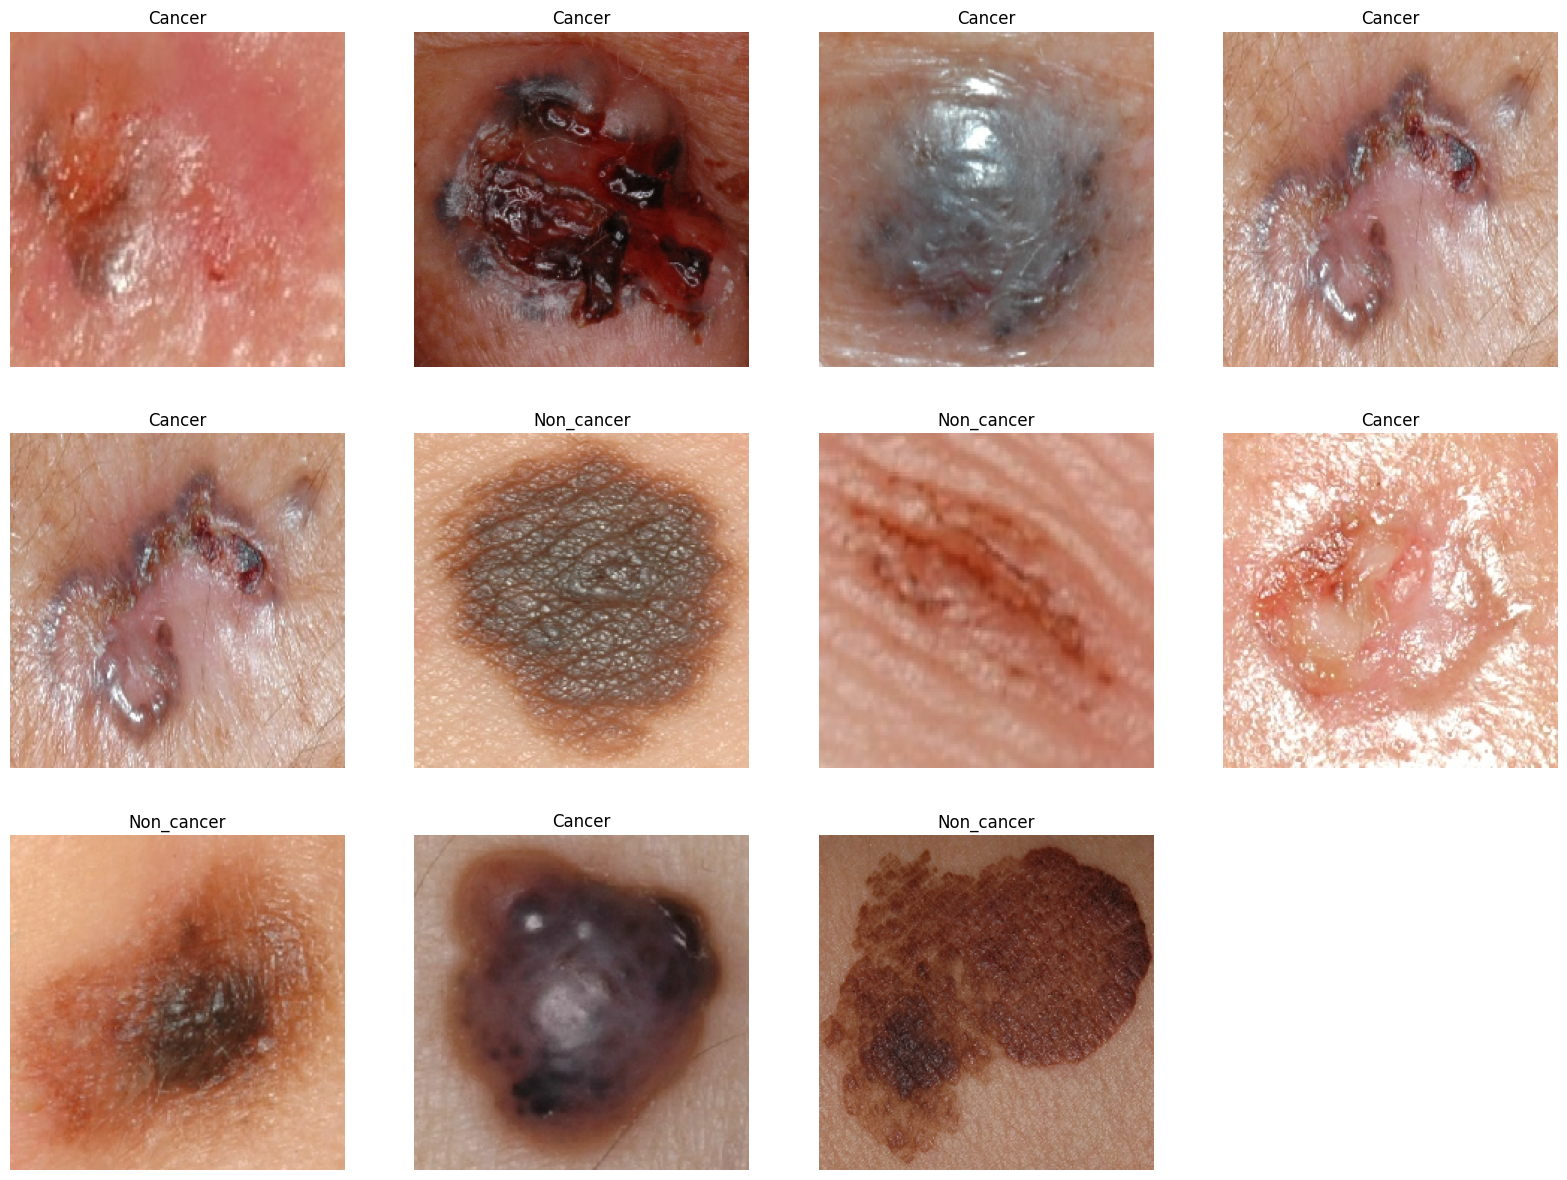

In [7]:
g_dict = train_gen.class_indices  # defines dictionary {'class': index}
classes = list(g_dict.keys())  # defines list of dictionary's keys (classes), class names : string
images, labels = next(train_gen)  # get a batch size samples from the generator

plt.figure(figsize=(20, 20))

for i in range(11):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255  # scales data to range (0 - 255)
    plt.imshow(image)
    index = np.argmax(labels[i])  # get image index
    if classes[index] == 'Non_Cancer':
        class_name = 'non_cancer'
    elif classes[index] == 'malignant':
        class_name = 'cancer'
    else:
        class_name = classes[index]
    plt.title(class_name, fontsize=12)
    plt.axis('off')
plt.show()

In [8]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (224,224,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 32)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 64)      2

In [9]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [10]:
history1 = model.fit(train_gen,
                    validation_data = test_gen,
                     batch_size = 64,
                    epochs = 50)

Epoch 1/50
6/6 [==============================] - 19s 479ms/step - loss: 1.2687 - accuracy: 0.6429 - val_loss: 20.4498 - val_accuracy: 0.2059
Epoch 2/50
6/6 [==============================] - 2s 347ms/step - loss: 0.5934 - accuracy: 0.7857 - val_loss: 53.0241 - val_accuracy: 0.2059
Epoch 3/50
6/6 [==============================] - 2s 345ms/step - loss: 0.5608 - accuracy: 0.8095 - val_loss: 37.5363 - val_accuracy: 0.2059
Epoch 4/50
6/6 [==============================] - 1s 189ms/step - loss: 0.3134 - accuracy: 0.8571 - val_loss: 15.9390 - val_accuracy: 0.2059
Epoch 5/50
6/6 [==============================] - 1s 172ms/step - loss: 0.2695 - accuracy: 0.8929 - val_loss: 8.2769 - val_accuracy: 0.2206
Epoch 6/50
6/6 [==============================] - 1s 160ms/step - loss: 0.1904 - accuracy: 0.9286 - val_loss: 5.6867 - val_accuracy: 0.2304
Epoch 7/50
6/6 [==============================] - 1s 161ms/step - loss: 0.1949 - accuracy: 0.9167 - val_loss: 3.5747 - val_accuracy: 0.2402
Epoch 8/50
6/6 

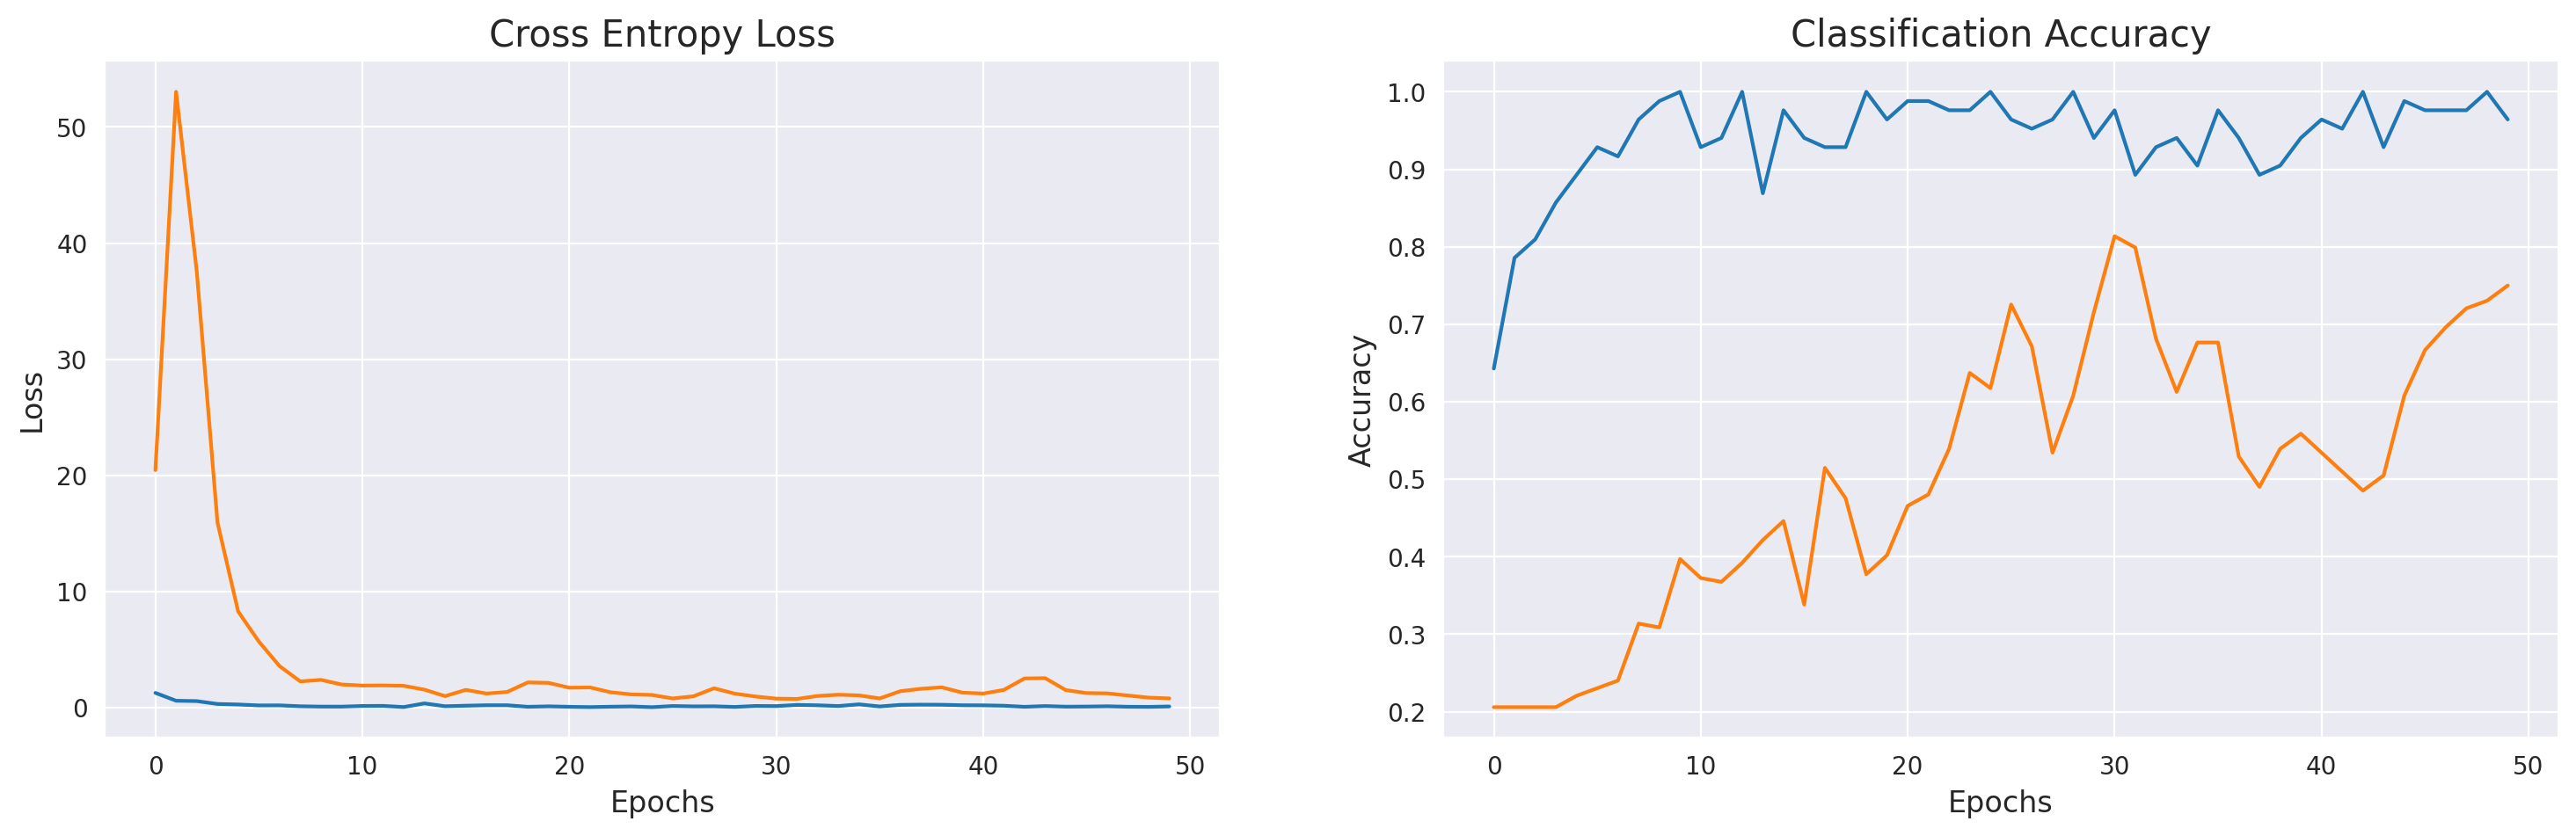

In [11]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [12]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_gen)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)


6/6 [==============================] - 0s 39ms/step - loss: 0.0797 - accuracy: 0.9881
The accuracy of the model for training data is: 98.8095223903656
The Loss of the model for training data is: 0.07967093586921692


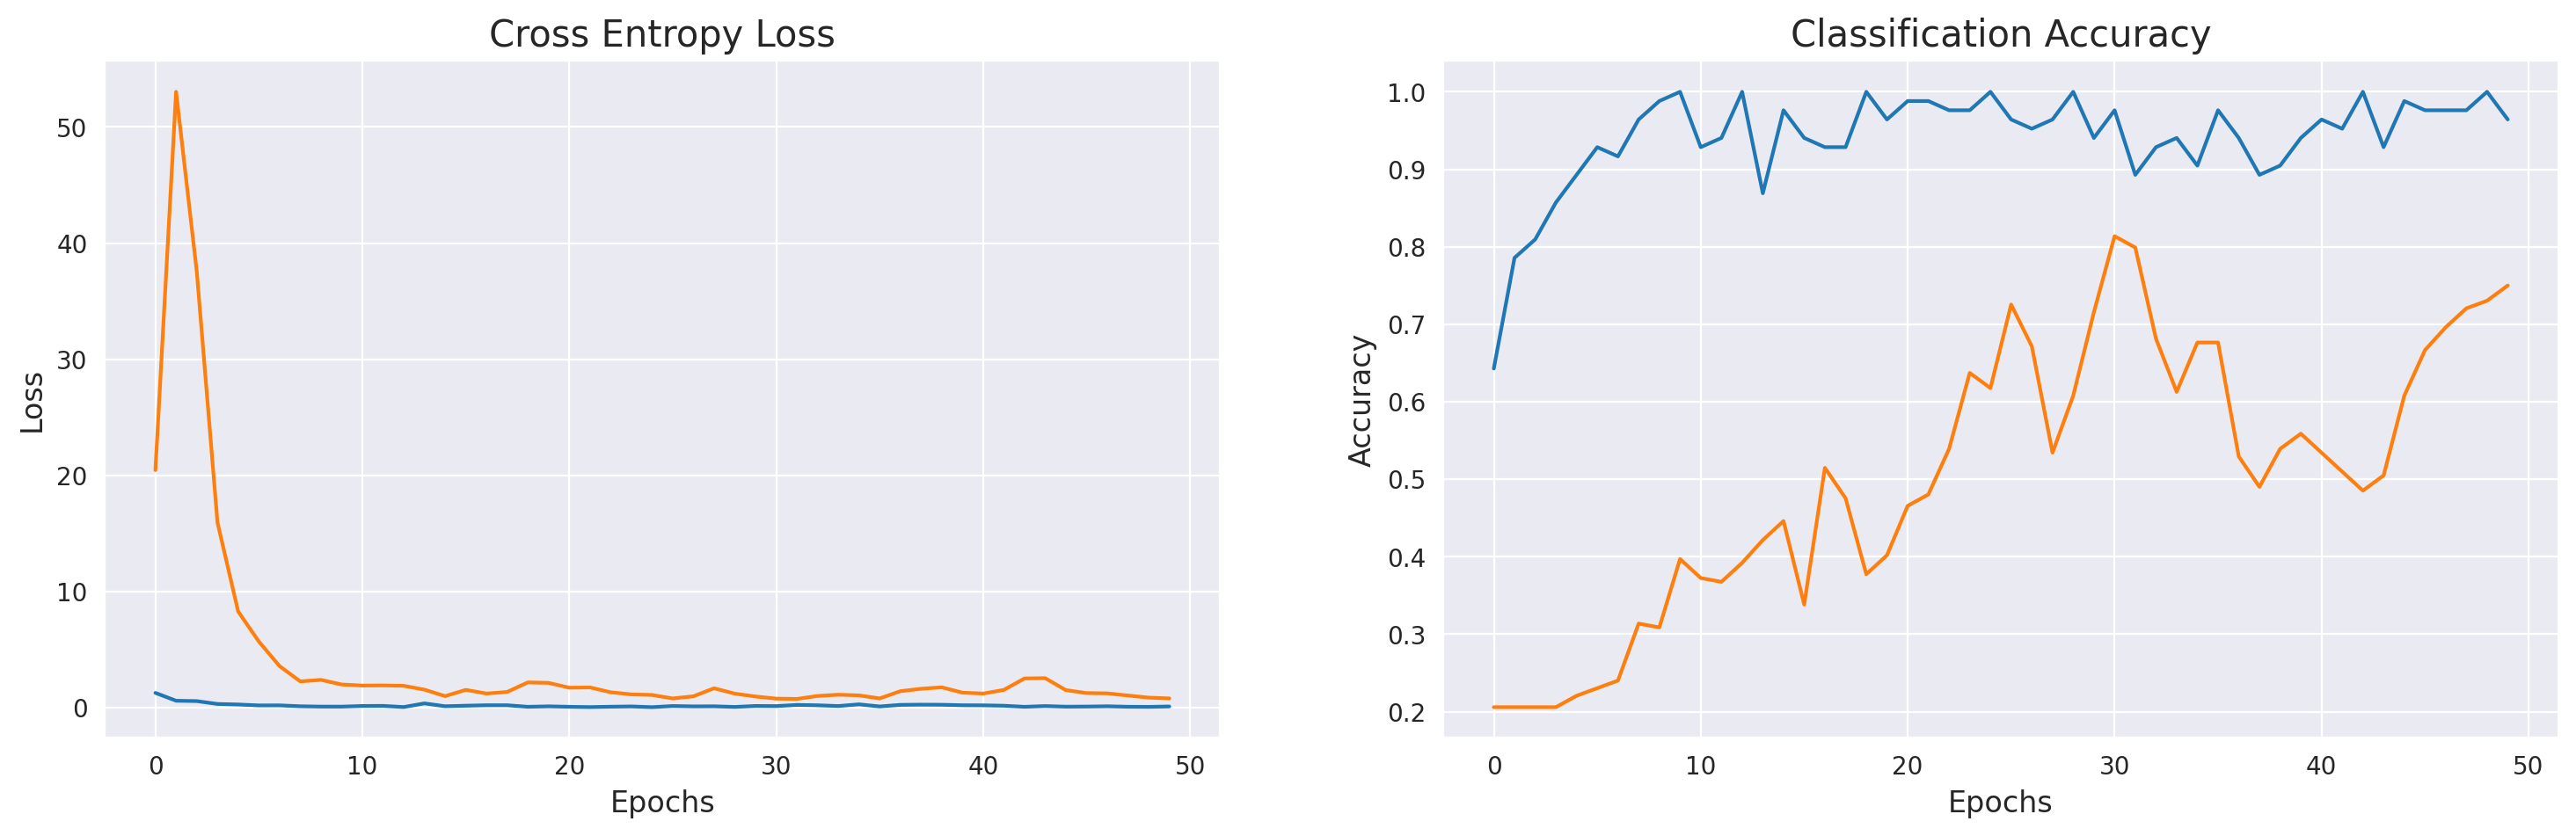

In [13]:
error = pd.DataFrame(history1.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [14]:
# prediction
result = model.predict(test_gen)

y_pred = np.argmax(result, axis = 1)

y_true = test_gen.labels

# Evaluvate
loss,acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 [==============================] - 1s 37ms/step - loss: 0.7933 - accuracy: 0.7500
The accuracy of the model for testing data is: 75.0
The Loss of the model for testing data is: 0.7933117747306824


In [15]:
print(classification_report(y_true, y_pred,target_names=classes))

              precision    recall  f1-score   support

      Cancer       0.42      0.60      0.50        42
  Non_cancer       0.88      0.79      0.83       162

    accuracy                           0.75       204
   macro avg       0.65      0.69      0.66       204
weighted avg       0.79      0.75      0.76       204



Resnet50


In [74]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [75]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)
model_resnet = Model(inputs=base_model.input, outputs=predictions)

In [76]:
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [77]:
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [78]:
history_resnet = model_resnet.fit(train_gen,
                           validation_data=test_gen,
                           batch_size=64,
                           epochs=30)

Epoch 1/30
6/6 [==============================] - 41s 1s/step - loss: 0.5558 - accuracy: 0.7143 - val_loss: 0.3765 - val_accuracy: 0.8431
Epoch 2/30
6/6 [==============================] - 3s 420ms/step - loss: 0.0747 - accuracy: 0.9762 - val_loss: 0.6572 - val_accuracy: 0.8088
Epoch 3/30
6/6 [==============================] - 2s 438ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 0.7565 - val_accuracy: 0.8137
Epoch 4/30
6/6 [==============================] - 2s 356ms/step - loss: 0.0353 - accuracy: 0.9881 - val_loss: 0.7450 - val_accuracy: 0.8235
Epoch 5/30
6/6 [==============================] - 2s 308ms/step - loss: 0.0939 - accuracy: 0.9762 - val_loss: 0.6353 - val_accuracy: 0.8333
Epoch 6/30
6/6 [==============================] - 2s 429ms/step - loss: 0.0152 - accuracy: 1.0000 - val_loss: 0.4586 - val_accuracy: 0.8578
Epoch 7/30
6/6 [==============================] - 2s 354ms/step - loss: 0.0267 - accuracy: 0.9881 - val_loss: 0.3434 - val_accuracy: 0.8775
Epoch 8/30
6/6 [======

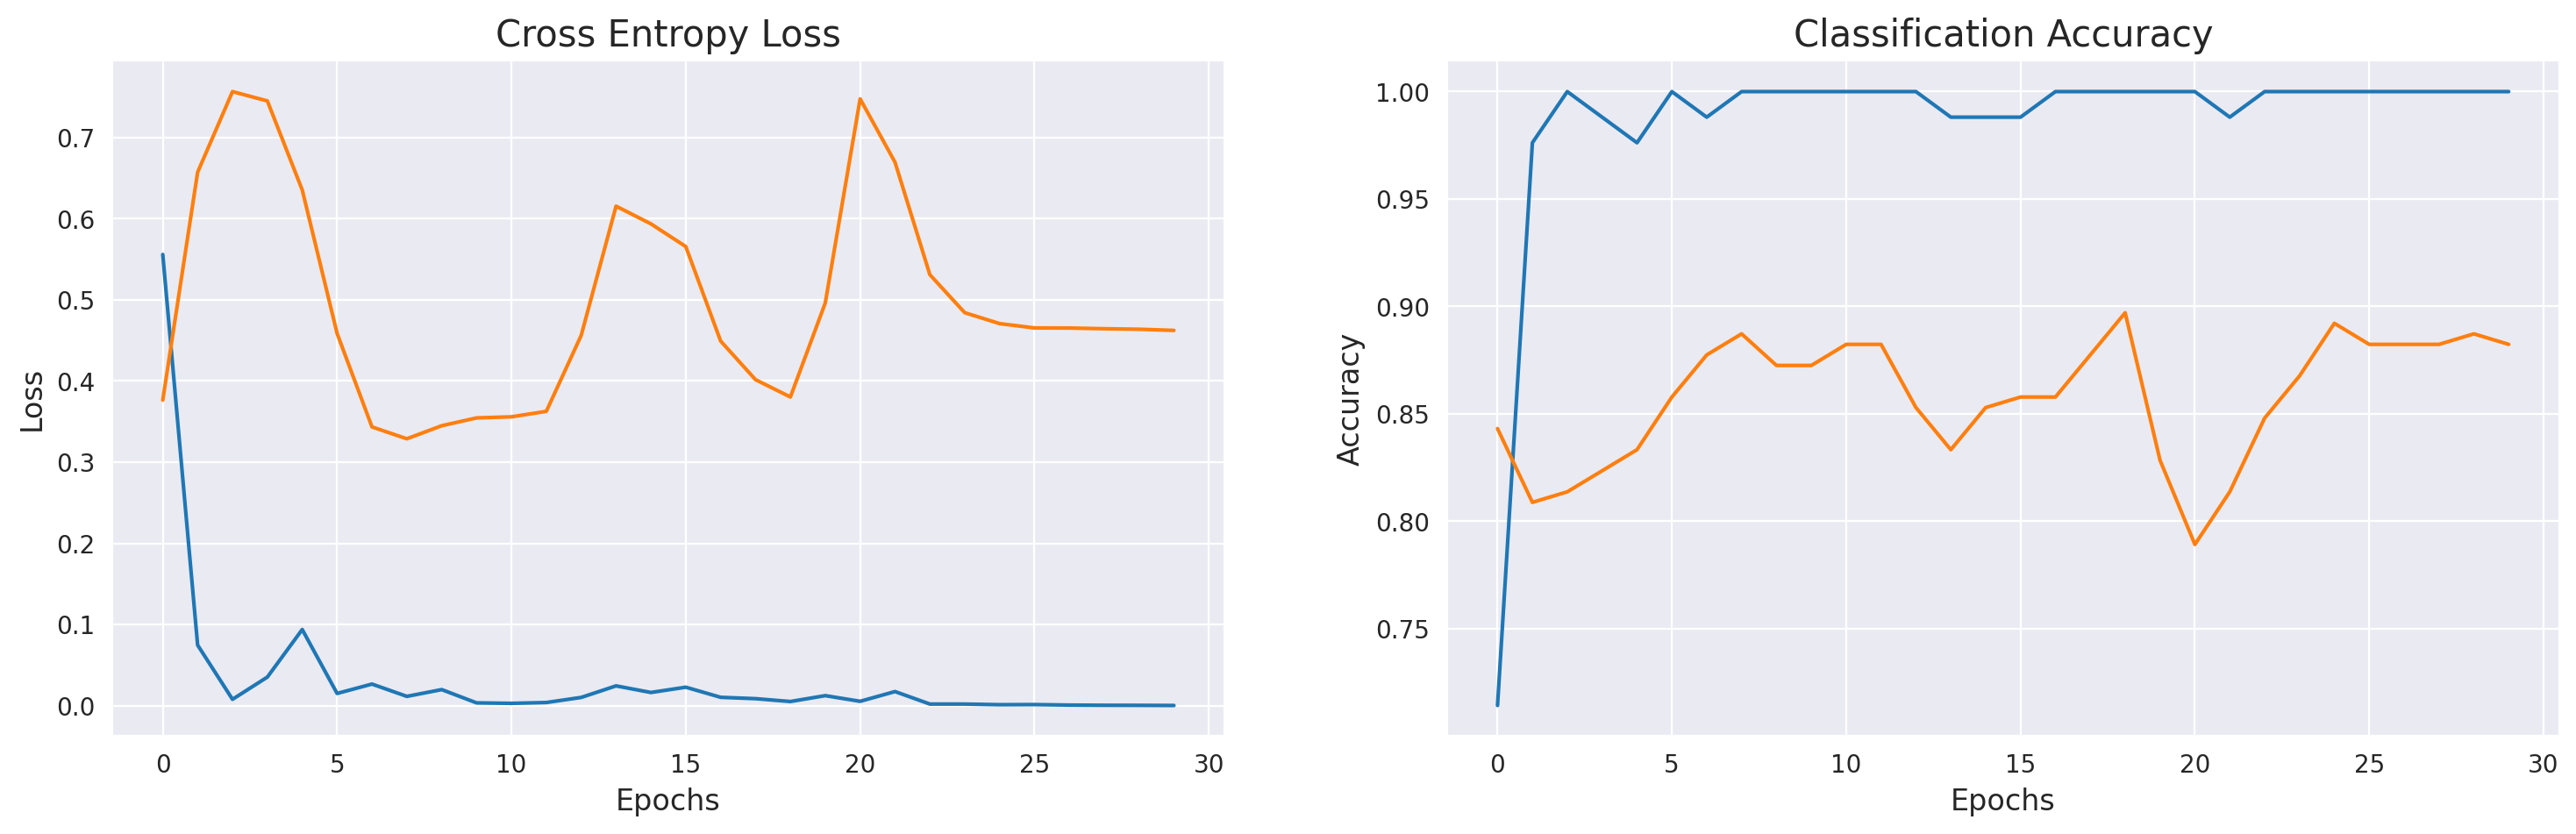

In [84]:
error_resnet = pd.DataFrame(history_resnet.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_resnet['loss'])
plt.plot(error_resnet['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_resnet['accuracy'])
plt.plot(error_resnet['val_accuracy'])

plt.show()

In [85]:
# Prediction
result = model_resnet.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels

# Evaluvate
loss,acc = model_resnet.evaluate(test_gen)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

13/13 [==============================] - 1s 74ms/step - loss: 0.4623 - accuracy: 0.8824
The accuracy of the model for testing data is: 88.23529481887817
The Loss of the model for testing data is: 0.46231910586357117


In [86]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.11764705882352941


In [87]:
# After training your model, save it to a file
model.save('skin_cancer_resnet_model_1.h5')

In [83]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/skin_cancer_resnet_model_1.h5')  # Replace 'your_model_path.h5' with the actual path to your saved model

Found 204 validated image filenames belonging to 2 classes.
1/1 [==============================] - 0s 29ms/step


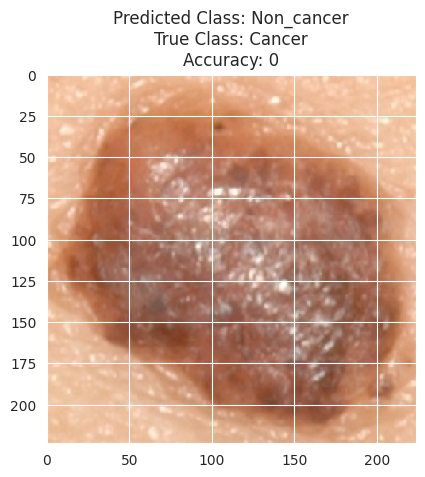

In [65]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the test data generator
test_data_dir = '/content/New_Skin_Data_1/Testing'  # Update with your test data path
ts_gen = ImageDataGenerator(rescale=1./255)  # Normalize the test data
test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=(224, 224), class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=1)

# Get a random image and its label from the test dataset
random_index = random.randint(0, len(test_gen) - 1)
random_image, random_label = test_gen[random_index]

# Make a prediction on the random image
prediction = model_resnet.predict(random_image)[0]

# Define class labels
class_labels = ['Non_cancer', 'Cancer']

# Get the predicted class and true class
predicted_class = class_labels[np.argmax(prediction)]
true_class = class_labels[np.argmax(random_label)]

# Calculate accuracy
accuracy = 1 if true_class == predicted_class else 0

# Display the random image, the prediction, and the accuracy
plt.imshow(random_image[0])  # No need to divide by 255 as rescaling is done in the generator
plt.title(f'Predicted Class: {predicted_class}\nTrue Class: {true_class}\nAccuracy: {accuracy}')
plt.show()

VGG16

In [28]:
from keras.applications import VGG16
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

In [29]:
# Load the pre-trained VGG16 model with ImageNet weights (excluding top classification layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 [==============================] - 0s 0us/step


In [30]:
# Add custom layers on top of the VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

In [31]:
# Create the new model with the custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
# Data directories and parameters
train_data_dir = '/content/New_Skin_Data_1/Training'
test_data_dir = '/content/New_Skin_Data_1/Testing'
batch_size = 16
img_size = (224, 224)
channels = 3

In [33]:
# Create data generators
tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels',
                                      target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels',
                                     target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


Found 84 validated image filenames belonging to 2 classes.
Found 204 validated image filenames belonging to 2 classes.


In [34]:
# Train the model
history_vgg16 = model.fit(train_gen,
                         validation_data=test_gen,
                         batch_size=64,
                         epochs=30)

Epoch 1/30
6/6 [==============================] - 16s 1s/step - loss: 0.9725 - accuracy: 0.4881 - val_loss: 0.7813 - val_accuracy: 0.2255
Epoch 2/30
6/6 [==============================] - 2s 368ms/step - loss: 0.6709 - accuracy: 0.5238 - val_loss: 0.9435 - val_accuracy: 0.2598
Epoch 3/30
6/6 [==============================] - 2s 358ms/step - loss: 0.6074 - accuracy: 0.6667 - val_loss: 1.3341 - val_accuracy: 0.2549
Epoch 4/30
6/6 [==============================] - 2s 358ms/step - loss: 0.7024 - accuracy: 0.6429 - val_loss: 0.5569 - val_accuracy: 0.7598
Epoch 5/30
6/6 [==============================] - 2s 362ms/step - loss: 0.6048 - accuracy: 0.7024 - val_loss: 0.4448 - val_accuracy: 0.7990
Epoch 6/30
6/6 [==============================] - 2s 360ms/step - loss: 0.6696 - accuracy: 0.5833 - val_loss: 0.6923 - val_accuracy: 0.4951
Epoch 7/30
6/6 [==============================] - 2s 381ms/step - loss: 0.5818 - accuracy: 0.6548 - val_loss: 0.5814 - val_accuracy: 0.8088
Epoch 8/30
6/6 [======

In [35]:
# Make predictions
result = model.predict(test_gen)
y_pred = result.argmax(axis=1)
y_true = test_gen.labels
# Evaluate
loss, acc = model.evaluate(test_gen)

print('The accuracy of the model for testing data is:', acc * 100)
print('The Loss of the model for testing data is:', loss)


13/13 [==============================] - 1s 73ms/step - loss: 0.4631 - accuracy: 0.8284
The accuracy of the model for testing data is: 82.84313678741455
The Loss of the model for testing data is: 0.46311044692993164


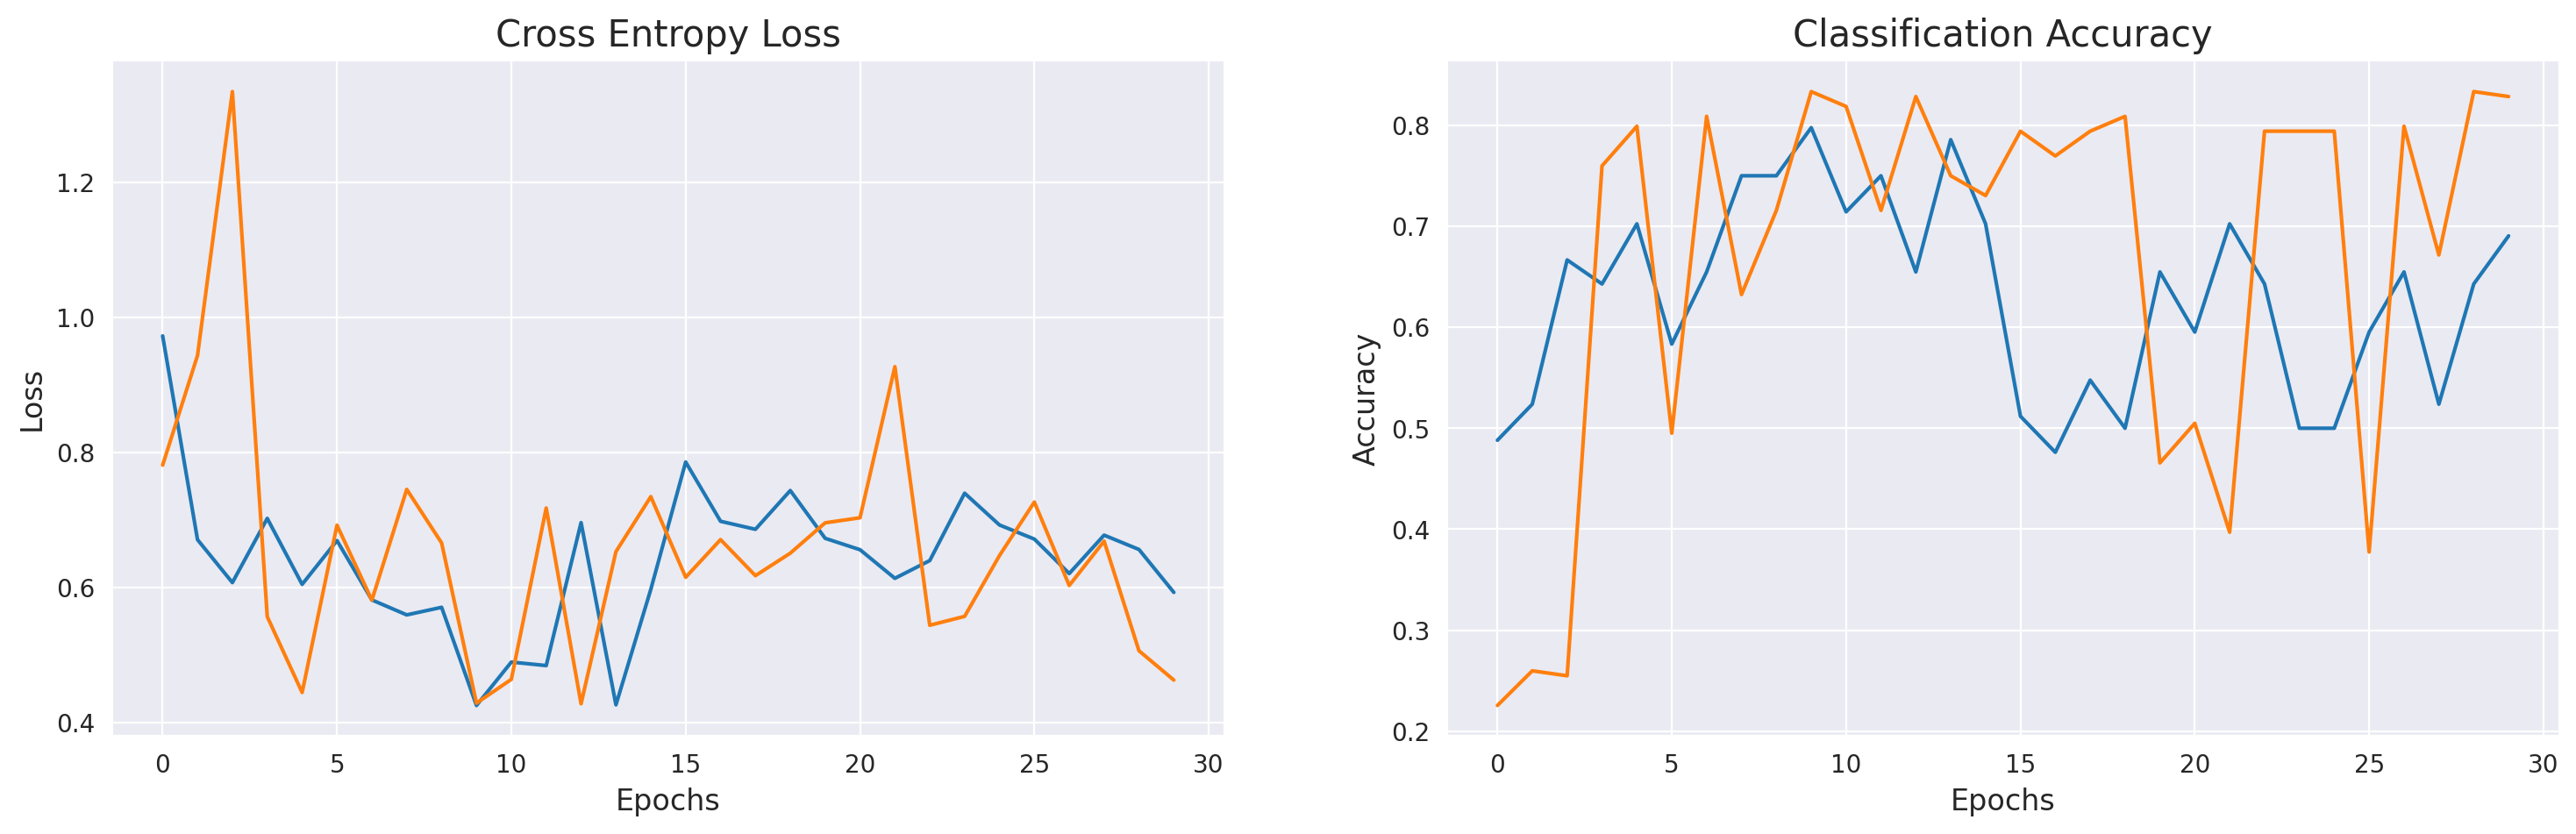

In [36]:
error_vgg16 = pd.DataFrame(history_vgg16.history)

plt.figure(figsize=(18, 5), dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.plot(error_vgg16['loss'])
plt.plot(error_vgg16['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy', fontsize=15)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.plot(error_vgg16['accuracy'])
plt.plot(error_vgg16['val_accuracy'])

plt.show()


In [37]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_true, y_pred)
print('The Mean Squared Error (MSE) for the model is:', mse)


The Mean Squared Error (MSE) for the model is: 0.1715686274509804
